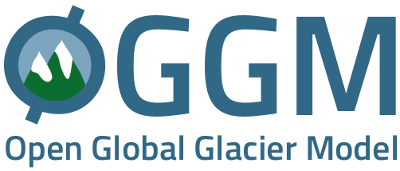

# Getting started with flowline models: idealized experiments

In this notebook we are going to explore the basic functionalities of OGGM flowline model(s). For this purpose we are going to use simple, "idealized" glaciers, run with simple linear mass-balance profiles. 

In [1]:
# The commands below are just importing the necessary modules and functions
# Plot defaults
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (9, 6)  # Default plot size
# Scientific packages
import numpy as np

# Constants
from oggm import cfg
cfg.initialize()
# OGGM models
from oggm.core.massbalance import LinearMassBalance
from oggm.core.flowline import FluxBasedModel, RectangularBedFlowline, TrapezoidalBedFlowline, ParabolicBedFlowline
# There are several solvers in OGGM core. We use the default one for this experiment
FlowlineModel = FluxBasedModel


import hide_functions as hf

2018-12-27 11:16:52: oggm.cfg: Using configuration file: /home/zora/Dokumente/git/oggm/oggm/params.cfg


## Basics

Set-up a simple run with a constant linear bed. We will first define the bed:

### Glacier bed

In [2]:
# This is the bed rock, linearily decreasing from 3400 m altitude to 1400 m, in 200 steps
nx = 200
bed_h = np.linspace(3400, 1400, nx)
# At the beginning, there is no glacier so our glacier surface is at the bed altitude
surface_h = bed_h
# Let's set the model grid spacing to 100 m 
map_dx = 100
# Calculate the corresponding distance along the glacier (from the top)
distance_along_glacier = np.linspace(0, nx, nx) * 0.1 # in km 

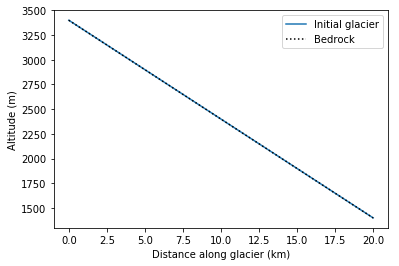

In [3]:
# Plot it
plt.plot(distance_along_glacier, surface_h, label='Initial glacier')
hf.plot_xz_bed(x=distance_along_glacier, bed=bed_h);

Now we have to decide how wide our glacier is, and what the *shape* of its bed is. For a start, we will use a "u-shaped" bed (see the [documentation](http://docs.oggm.org/en/latest/ice-dynamics.html#rectangular)), with a constant width of 300m:

In [4]:
# The units of widths is in "grid points", i.e. 3 grid points = 300 m in our case
widths = np.zeros(nx) + 3.
# Define our bed
init_flowline = RectangularBedFlowline(surface_h=surface_h, bed_h=bed_h, widths=widths, map_dx=map_dx)

The init_flowline variable now contains all geometrical information needed by the model. It can give access to some attributes, which are quite useless for a non-existing glacier: 

In [5]:
print('Glacier length:', init_flowline.length_m)
print('Glacier area:', init_flowline.area_km2)
print('Glacier volume:', init_flowline.volume_km3)

Glacier length: 0.0
Glacier area: 0.0
Glacier volume: 0.0


### Mass balance

Then we will need a mass balance model. In our case this will be a simple linear mass-balance, defined by the equilibrium line altitude (ELA) and an altitude gradient (in [mm m$^{-1}$]):

In [6]:
# ELA at 3000m a.s.l., gradient 4 mm m-1
mb_model = LinearMassBalance(3000, grad=4)

The mass-balance model gives you the mass-balance for any altitude you want, in units [m s$^{-1}$]. Let us compute the *annual* mass-balance along the glacier profile:

In [7]:
annual_mb = mb_model.get_annual_mb(surface_h) * cfg.SEC_IN_YEAR

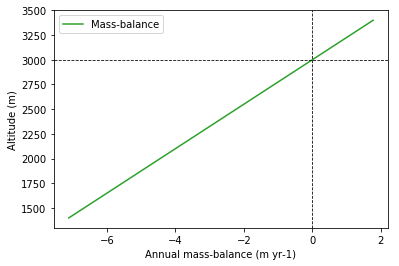

In [8]:
# Plot it
plt.plot(annual_mb, bed_h, color='C2', label='Mass-balance')
plt.xlabel('Annual mass-balance (m yr-1)')
plt.ylabel('Altitude (m)')
plt.legend(loc='best')
# Display equilibrium line altitude, where annual mass-balance = 0
plt.axvline(x=0, color='k', linestyle='--', linewidth=0.8)
plt.axhline(y=mb_model.ela_h, color='k', linestyle='--', linewidth=0.8);

### Model run

Now that we have all the ingredients to run the model, we just have to initialize it:

In [9]:
# The model requires the initial glacier bed, a mass-balance model, and an initial time (the year y0)
model = FlowlineModel(init_flowline, mb_model=mb_model, y0=0.)

Let's first run the model for one year:

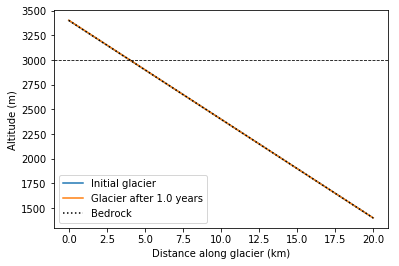

In [10]:
hf.glacier(runtime=1, x=distance_along_glacier, bed=bed_h, model=model, mb_model=mb_model, init_flowline=init_flowline)

In [ ]:
print('Year:', model.yr)
print('Glacier length (m):', model.length_m)
print('Glacier area (km2):', model.area_km2)
print('Glacier volume (km3):', model.volume_km3)

The modeled 'glacier' fills already the whole bed and its length goes up to the ELA (dashed line), but it is extremely thin. 

We can now run the model for 150 years and see how the output looks like:

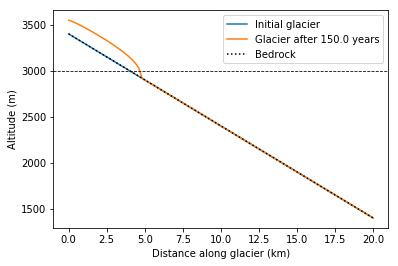

In [14]:
hf.glacier(runtime=150, x=distance_along_glacier, bed=bed_h, model=model, mb_model=mb_model, init_flowline=init_flowline)

Let's print out a few infos about our glacier:

In [ ]:
print('Year:', model.yr)
print('Glacier length (m):', model.length_m)
print('Glacier area (km2):', model.area_km2)
print('Glacier volume (km3):', model.volume_km3)

Note that the model time is now 150 years. Running the model with the same input again, calls the already calculated results but does not execute the method `model.run_until` another time, which safes computational time. 



In [ ]:
model.run_until(150)
print('Year:', model.yr)
print('Glacier length (m):', model.length_m)

If we want to compute longer, we have to set the desired date. Hereby, the model computes only the additional missing years.

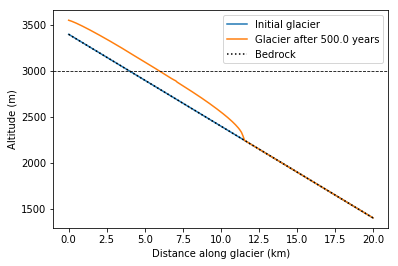

In [17]:
hf.glacier(runtime=500, x=distance_along_glacier, bed=bed_h, model=model, mb_model=mb_model, init_flowline=init_flowline)

In [19]:
print('Year:', model.yr)
print('Glacier length (m):', model.length_m)
print('Glacier area (km2):', model.area_km2)
print('Glacier volume (km3):', model.volume_km3)

Year: 500.0
Glacier length (m): 11500.0
Glacier area (km2): 3.4499999999999997
Glacier volume (km3): 0.6160637242901909


However, it is important to note, that the model will not calculate back in time.
Once calculated for 500 years, the model will not run again for 450 years and remains at 500 years.

In [ ]:
model.run_until(450)
print('Year:', model.yr)
print('Glacier length (m):', model.length_m)

Note that in order to store some intermediate steps of the evolution of the glacier, it might be useful to make a loop:

In [ ]:
# Reinitialize the model
model = FlowlineModel(init_flowline, mb_model=mb_model, y0=0.)
# Year 0 to 600 in 5 years step
yrs = np.arange(0, 601, 5) 
# Array to fill with data
nsteps = len(yrs)
length = np.zeros(nsteps)
vol = np.zeros(nsteps)
# Loop
for i, yr in enumerate(yrs):
    model.run_until(yr)
    length[i] = model.length_m
    vol[i] = model.volume_km3
# I store the final results for later use
simple_glacier_h = model.fls[-1].surface_h

We can now plot the evolution of the glacier length and volume with time:

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.plot(yrs, length);
ax1.set_xlabel('Years')
ax1.set_ylabel('Length (m)');
ax2.plot(yrs, vol);
ax2.set_xlabel('Years')
ax2.set_ylabel('Volume (km3)');

The glacier grows in length in the first year of simulation until it reaches the equilibrium line altitude (ELA).
After that, the glacier's length remains first constant. This behavior can be explained by the fact that above the ELA, the mass balance is positive, unimportant how large the glacier is. As long as the glacier is not thick enough, no ice remains below the ELA, because the ablation below the ELA is higher than the amount of ice froming the glacier flow. 

In [ ]:
print('Glacier length from the top to the equilibrium line altitude ('+str(mb_model.ela_h)+' m) is: ' 
      + str(length[1])+'m')

After several centuries, the glacier gets in balance with its climate. Its length and volume won't change anymore, if all physical parameters and the climate stay constant.

## A first experiment 

Ok, now we have seen the basics. We will now define a simple experiment, in which we will make the glacier wider at the top (in the accumulation area). This is a common situation for valley glaciers.

In [ ]:
# We define the widths as before:
widths = np.zeros(nx) + 3.
# But we now make our glacier 600 m wide for the first grid points:
widths[0:15] = 6
# Define our new bed
wider_flowline = RectangularBedFlowline(surface_h=surface_h, bed_h=bed_h, widths=widths, map_dx=map_dx)

We will now run our model with the new inital conditions (again for 600 years), and store the output in a new variable for comparison:

In [ ]:
# Reinitialize the model with the new input
model = FlowlineModel(wider_flowline, mb_model=mb_model, y0=0.)
# Array to fill with data
nsteps = len(yrs)
length_w = np.zeros(nsteps)
vol_w = np.zeros(nsteps)
# Loop
for i, yr in enumerate(yrs):
    model.run_until(yr)
    length_w[i] = model.length_m
    vol_w[i] = model.volume_km3
# I store the final results for later use
wider_glacier_h = model.fls[-1].surface_h

Compare the results:

In [ ]:
# Plot the final result:
plt.plot(distance_along_glacier, simple_glacier_h, label='Simple glacier')
plt.plot(distance_along_glacier, wider_glacier_h, label='Wider glacier')
# Add the bedrock:
hf.plot_xz_bed(x= distance_along_glacier, bed = bed_h);

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.plot(yrs, length, label='Simple glacier');
ax1.plot(yrs, length_w, label='Wider glacier');
ax1.legend(loc='best')
ax1.set_xlabel('Years')
ax1.set_ylabel('Length (m)');
ax2.plot(yrs, vol, label='Simple glacier');
ax2.plot(yrs, vol_w, label='Wider glacier');
ax2.legend(loc='best')
ax2.set_xlabel('Years')
ax2.set_ylabel('Volume (km3)');

Explanation text?